## 3. Getting Started with Neural Networks

### Classifying newswires: A Multiclass Classification Example
In the newswires problem, we want to classify newswires to one of 46 mutually exclusive topics. Since the number of classes is more than 2, this is a multiclass classification problem, extending from the binary classification problem.

In [1]:
from keras.datasets import reuters

import numpy as np
import pandas as pd

from keras.utils.np_utils import to_categorical
from keras import models
from keras import layers

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
##########
# Ingestion
##########
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

The data consists of 8982 training examples and 2246 test examples. Similarly each document is stored as a word vector.

In [3]:
# For testing
# print([td[:15] for td in train_data[0:3]])
# print(train_labels[0:3])

Preprocessing follows that in the reviews problem for the input data. 

For the labels, we can cast the label list as an integer tensor, or one-hot encode the categorical data. We will do one-hot encoding.

Note that if we use the integer tensor way, then the loss function will be `sparse_categorical_crossentropy`.

In [4]:
##########
# Preprocessing
##########
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
          results[i, sequence] = 1.
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

# Train-Validation Split
x_val, y_val = x_train[:1000], y_train[:1000]
partial_x_train, partial_y_train = x_train[1000:], y_train[1000:]

For this problem, a 16-dimensional space might be too limited to learn to separate 46 different classes. For this, we go with a larger layer with 64 units.

Also, for the last layer, we now use a softmax function because this is a multiclass problem with more than 2 classes. Note that the 46 probabilities from the output layer will sum to $1$ too.

The network ends with a dense layer of size 46 to represent the 46 different categories. Each entry will encode a different output class.

In [5]:
##########
# Train
##########
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

We use the same workflow and now will compile the model. This time the loss function changes to `categorical_crossentropy`.

In [6]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

We will train the network on 20 epochs

In [7]:
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 140us/step - loss: 2.7373 - accuracy: 0.4825 - val_loss: 1.8090 - val_accuracy: 0.6320
Epoch 2/20
7982/7982 [==============================] - 1s 95us/step - loss: 1.4921 - accuracy: 0.6928 - val_loss: 1.3274 - val_accuracy: 0.7150
Epoch 3/20
7982/7982 [==============================] - 1s 94us/step - loss: 1.0885 - accuracy: 0.7660 - val_loss: 1.1302 - val_accuracy: 0.7710
Epoch 4/20
7982/7982 [==============================] - 1s 94us/step - loss: 0.8502 - accuracy: 0.8232 - val_loss: 1.0199 - val_accuracy: 0.7830
Epoch 5/20
7982/7982 [==============================] - 1s 95us/step - loss: 0.6758 - accuracy: 0.8586 - val_loss: 0.9609 - val_accuracy: 0.8000
Epoch 6/20
7982/7982 [==============================] - 1s 94us/step - loss: 0.5411 - accuracy: 0.8882 - val_loss: 0.9181 - val_accuracy: 0.8180
Epoch 7/20
7982/7982 [==============================] - 1s 94us/step - loss: 0.43

Let's plot the loss and accuracy curves.

/Users/bryanlim/.pyenv/versions/3.7.2/envs/botanic/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/bryanlim/.pyenv/versions/3.7.2/envs/botanic/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/bryanlim/.pyenv/versions/3.7.2/envs/botanic/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.


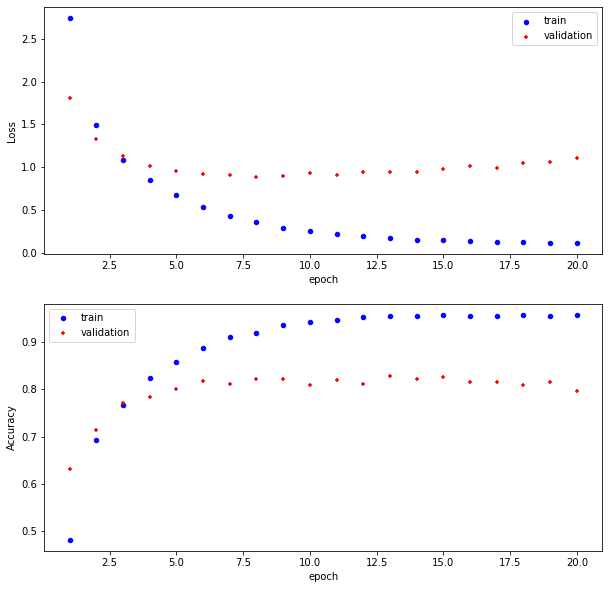

In [8]:
history_dict = history.history
metrics_df = pd.DataFrame({'loss' : history_dict['loss'], 
                           'val_loss' : history_dict['val_loss'],
                          'accuracy' : history_dict['accuracy'],
                          'val_accuracy' : history_dict['val_accuracy']})
metrics_df['epoch'] = metrics_df.index+1

fig = plt.figure(figsize=(10,10))
ax1, ax2 = fig.add_subplot(211), fig.add_subplot(212)
metrics_df.plot(kind='scatter', x='epoch', y='loss', ax=ax1, label='train', color='blue')
metrics_df.plot(kind='scatter', x='epoch', y='val_loss', ax=ax1, label='validation', color='red', marker='+')
ax1.set_ylabel("Loss")

metrics_df.plot(kind='scatter', x='epoch', y='accuracy', ax=ax2, label='train', color='blue')
metrics_df.plot(kind='scatter', x='epoch', y='val_accuracy', ax=ax2, label='validation', color='red', marker='+')
ax2.set_ylabel("Accuracy")
plt.show()

For this, the network starts to overfit after 6 epochs. So we train a new network on the 6 epochs and use this on the test set.

In [9]:
model2 = models.Sequential()
model2.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(46, activation='softmax'))

model2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model2.fit(partial_x_train, partial_y_train, epochs=6, batch_size=512, validation_data=(x_val, y_val))

results = model2.evaluate(x_test, y_test)
print(results)

Train on 7982 samples, validate on 1000 samples
Epoch 1/6
7982/7982 [==============================] - 1s 105us/step - loss: 2.6462 - accuracy: 0.4592 - val_loss: 1.7594 - val_accuracy: 0.6150
Epoch 2/6
7982/7982 [==============================] - 1s 95us/step - loss: 1.4456 - accuracy: 0.6842 - val_loss: 1.3326 - val_accuracy: 0.6990
Epoch 3/6
7982/7982 [==============================] - 1s 93us/step - loss: 1.0689 - accuracy: 0.7653 - val_loss: 1.1379 - val_accuracy: 0.7540
Epoch 4/6
7982/7982 [==============================] - 1s 93us/step - loss: 0.8396 - accuracy: 0.8191 - val_loss: 1.0357 - val_accuracy: 0.7820
Epoch 5/6
7982/7982 [==============================] - 1s 95us/step - loss: 0.6687 - accuracy: 0.8571 - val_loss: 0.9680 - val_accuracy: 0.7960
Epoch 6/6
2246/2246 [==============================] - 0s 117us/step
[1.015451033414737, 0.7715939283370972]


For the softmax problem, the output class is the class with the highest probability.

In [10]:
##########
# Predict
##########
prediction_probs = model2.predict(x_test)
print(prediction_probs[0].shape)
print(prediction_probs[0])
print(np.sum(prediction_probs[0])) # sums to 1
print(np.argmax(prediction_probs[0])) # sums to 1

(46,)
[8.06797703e-04 2.60573882e-03 2.41981965e-04 6.95302248e-01
 2.32037410e-01 2.07960402e-05 1.16088171e-03 1.03368395e-04
 8.64757411e-03 6.60895254e-04 9.67208063e-04 4.07889998e-03
 1.23639277e-03 2.42396677e-03 2.91733595e-04 1.75085908e-04
 1.72837470e-02 1.57513015e-03 1.21371727e-03 8.64391308e-03
 4.68883663e-03 6.72240742e-04 2.52051923e-05 1.36604800e-03
 1.89185230e-04 5.32534730e-04 8.09680147e-04 3.67804285e-04
 8.14260391e-04 3.54076736e-04 8.18590284e-04 2.34096521e-03
 4.06309642e-04 5.84049230e-05 5.34039165e-04 5.84027475e-05
 1.11027679e-03 5.21572365e-04 1.31368099e-04 2.82216282e-03
 3.11208161e-04 7.30226224e-04 1.74813773e-04 4.75863373e-04
 1.66758051e-04 4.16983821e-05]
1.0000001
3


Here is how to update the framing of the model when using the integer tensor.

In [11]:
ytrain2 = np.array(train_labels)
ytest2 = np.array(test_labels)

x_val2, y_val2 = x_train[:1000], ytrain2[:1000]
partial_x_train2, partial_y_train2 = x_train[1000:], ytrain2[1000:]

In [12]:
model3 = models.Sequential()
model3.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dense(46, activation='softmax'))

model3.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model3.fit(partial_x_train2, partial_y_train2, epochs=6, batch_size=512, validation_data=(x_val2, y_val2))

# results = model3.evaluate(x_test, y_test)
# print(results)

Train on 7982 samples, validate on 1000 samples
Epoch 1/6
7982/7982 [==============================] - 1s 107us/step - loss: 2.4762 - accuracy: 0.5435 - val_loss: 1.6615 - val_accuracy: 0.6560
Epoch 2/6
7982/7982 [==============================] - 1s 96us/step - loss: 1.3706 - accuracy: 0.7154 - val_loss: 1.2748 - val_accuracy: 0.7060
Epoch 3/6
7982/7982 [==============================] - 1s 98us/step - loss: 1.0188 - accuracy: 0.7838 - val_loss: 1.1197 - val_accuracy: 0.7580
Epoch 4/6
7982/7982 [==============================] - 1s 97us/step - loss: 0.7975 - accuracy: 0.8302 - val_loss: 1.0350 - val_accuracy: 0.7690
Epoch 5/6
7982/7982 [==============================] - 1s 96us/step - loss: 0.6401 - accuracy: 0.8634 - val_loss: 0.9564 - val_accuracy: 0.8040
Epoch 6/6
7982/7982 [==============================] - 1s 97us/step - loss: 0.5089 - accuracy: 0.8914 - val_loss: 0.9248 - val_accuracy: 0.8040


In [13]:
##########
# Predict using the integer tensor method
##########
prediction_probs2 = model3.predict(x_test)
print(prediction_probs2[0].shape)
print(prediction_probs2[0])
print(np.sum(prediction_probs2[0])) # sums to 1
print(np.argmax(prediction_probs2[0])) # sums to 1

(46,)
[2.06686527e-04 8.77269485e-04 9.71764457e-05 8.44638050e-01
 1.23873547e-01 4.61997661e-06 2.73858517e-04 3.05777503e-05
 9.97911766e-03 6.82906481e-04 3.90760426e-04 5.92695409e-03
 1.74163055e-04 2.39608329e-04 5.41926347e-05 3.14471654e-05
 2.26091710e-03 3.28956317e-04 4.24944417e-04 2.73963530e-03
 1.24907040e-03 4.71709005e-04 2.10899470e-05 1.18002517e-03
 1.07403685e-04 5.56442596e-04 5.16458131e-05 5.38591194e-05
 6.95626601e-04 6.73129325e-05 2.17667519e-04 8.91245509e-05
 6.43639287e-05 5.81098539e-06 1.44697433e-05 1.44277710e-05
 6.51146285e-04 6.57829733e-05 6.23757160e-06 9.39957332e-04
 3.63233376e-05 1.02541628e-04 2.07102348e-05 3.38242826e-05
 6.26993278e-06 4.18588097e-05]
1.0
3
